# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

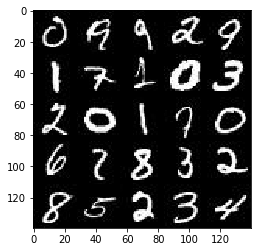

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

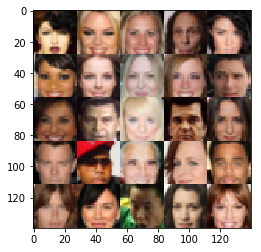

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_ = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(dtype=tf.float32, shape=None)
    return input_, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28
        conv1 = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, strides=2, activation=None)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 14*14
        
        conv2 = tf.layers.conv2d(inputs=conv1, filters=256, kernel_size=5, strides=2, activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 7*7

        flat = tf.reshape(conv2, (-1, 4*4*512))
        logits = tf.layers.dense(inputs=flat, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        fc = tf.layers.dense(inputs=z, units=7*7*512, activation=None)
        conv1 = tf.reshape(fc, shape=(-1, 7, 7, 512))
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=is_train)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 7*7
        
        conv2 = tf.layers.conv2d_transpose(inputs=conv1, filters=256, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=is_train)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 14*14
        
        # Output layer, 28*28
        logits = tf.layers.conv2d_transpose(inputs=conv2, filters=out_channel_dim, kernel_size=5, strides=2, padding='SAME', activation=None)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    show_every = 50
    print_every = 10
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        losses = []
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, len(data_image_mode), data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 0.2787... Generator Loss: 1.4257
Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 3.1293
Epoch 1/1... Discriminator Loss: 0.0428... Generator Loss: 3.1773
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 3.8459


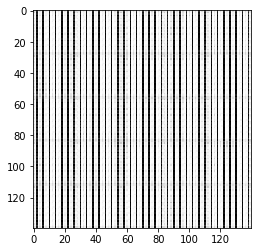

Epoch 1/1... Discriminator Loss: 0.0141... Generator Loss: 4.2926
Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 4.6961
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 4.8213
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 5.1866
Epoch 1/1... Discriminator Loss: 0.0079... Generator Loss: 4.9235


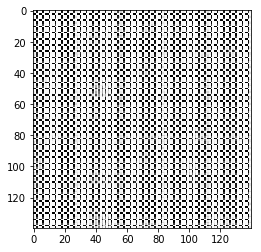

Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 5.7671
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 5.8139
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 5.7775
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 5.6911
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 6.4205


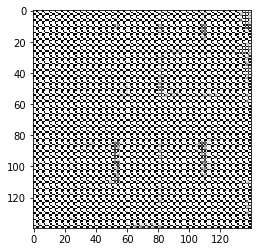

Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.3914
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.4835
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 6.3915
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.6700
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.6853


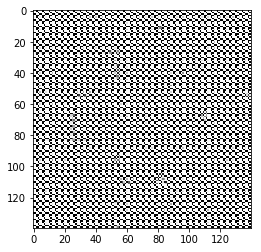

Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.0623
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.1781
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.0930
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.2234
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.3672


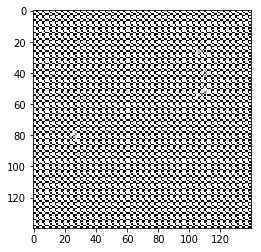

Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.4390
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.5053
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.5717
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.6394
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 7.6943


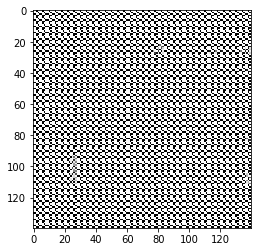

Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.7440
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.7883
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8412
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8676
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8632


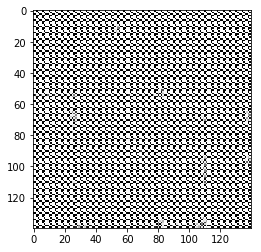

Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8605
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.0813
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1213
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1645
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1894


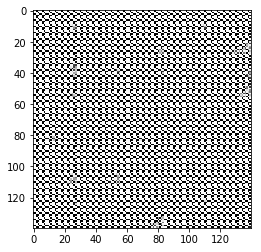

Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2040
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1991
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1298
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.8912
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.3536


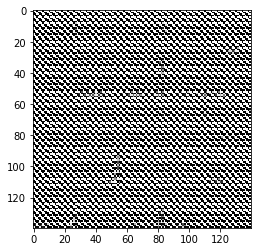

Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.4755
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.2514
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.4415
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.5354
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 8.0277


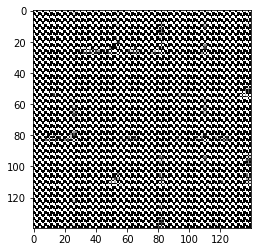

Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.8122
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 7.3688
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 8.6618
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.1520
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 8.3936


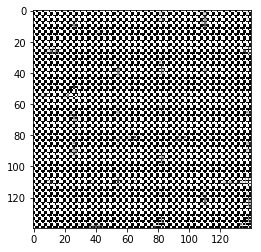

Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 7.9275
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 6.7270
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 7.8893
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 6.9784
Epoch 1/1... Discriminator Loss: 0.0538... Generator Loss: 3.7091


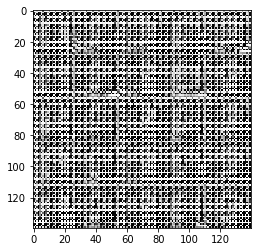

Epoch 1/1... Discriminator Loss: 0.1622... Generator Loss: 13.8156
Epoch 1/1... Discriminator Loss: 15.7423... Generator Loss: 21.5520
Epoch 1/1... Discriminator Loss: 4.9584... Generator Loss: 2.0044
Epoch 1/1... Discriminator Loss: 4.0330... Generator Loss: 3.0491
Epoch 1/1... Discriminator Loss: 4.2342... Generator Loss: 2.3827


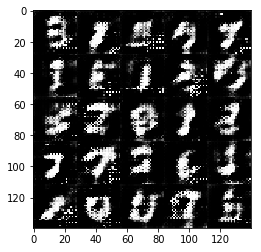

Epoch 1/1... Discriminator Loss: 4.6985... Generator Loss: 0.0522
Epoch 1/1... Discriminator Loss: 3.8045... Generator Loss: 0.0406
Epoch 1/1... Discriminator Loss: 3.7293... Generator Loss: 0.0420
Epoch 1/1... Discriminator Loss: 2.7831... Generator Loss: 0.1316
Epoch 1/1... Discriminator Loss: 3.0128... Generator Loss: 0.0738


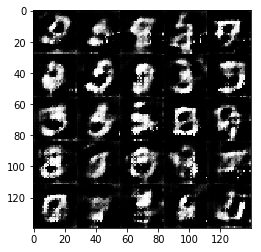

Epoch 1/1... Discriminator Loss: 2.7334... Generator Loss: 0.1027
Epoch 1/1... Discriminator Loss: 2.5277... Generator Loss: 0.1148
Epoch 1/1... Discriminator Loss: 2.3513... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 1.8497... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 2.2015... Generator Loss: 0.1628


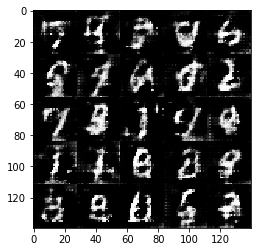

Epoch 1/1... Discriminator Loss: 2.1405... Generator Loss: 0.2033
Epoch 1/1... Discriminator Loss: 2.1279... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.7268... Generator Loss: 0.2963
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.9200


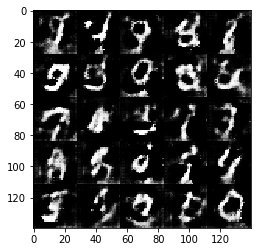

Epoch 1/1... Discriminator Loss: 1.8957... Generator Loss: 0.2123
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.8338... Generator Loss: 1.8130
Epoch 1/1... Discriminator Loss: 1.8947... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 1.0748


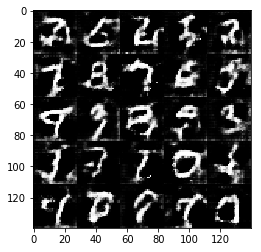

Epoch 1/1... Discriminator Loss: 1.8883... Generator Loss: 0.2149
Epoch 1/1... Discriminator Loss: 1.6117... Generator Loss: 0.2992
Epoch 1/1... Discriminator Loss: 2.1536... Generator Loss: 0.1528
Epoch 1/1... Discriminator Loss: 2.0958... Generator Loss: 0.1664
Epoch 1/1... Discriminator Loss: 2.1768... Generator Loss: 0.1715


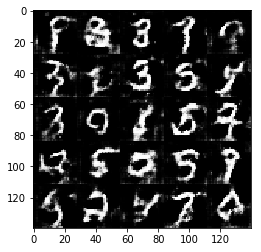

Epoch 1/1... Discriminator Loss: 1.8110... Generator Loss: 2.0335
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 2.0309... Generator Loss: 2.3595


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 0.8865
Epoch 1/2... Discriminator Loss: 0.4253... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 0.2797... Generator Loss: 1.4406
Epoch 1/2... Discriminator Loss: 0.1845... Generator Loss: 1.8115


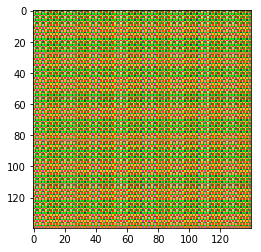

Epoch 1/2... Discriminator Loss: 0.1260... Generator Loss: 2.1538
Epoch 1/2... Discriminator Loss: 0.0736... Generator Loss: 2.7002
Epoch 1/2... Discriminator Loss: 0.0770... Generator Loss: 2.6310
Epoch 1/2... Discriminator Loss: 0.0516... Generator Loss: 3.0861
Epoch 1/2... Discriminator Loss: 0.0321... Generator Loss: 3.5116


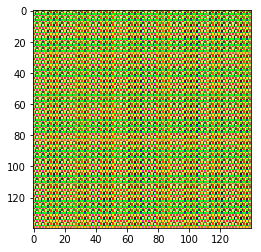

Epoch 1/2... Discriminator Loss: 0.0234... Generator Loss: 3.7855
Epoch 1/2... Discriminator Loss: 0.0194... Generator Loss: 3.9751
Epoch 1/2... Discriminator Loss: 0.0201... Generator Loss: 3.9434
Epoch 1/2... Discriminator Loss: 0.0157... Generator Loss: 4.1626
Epoch 1/2... Discriminator Loss: 0.0133... Generator Loss: 4.3308


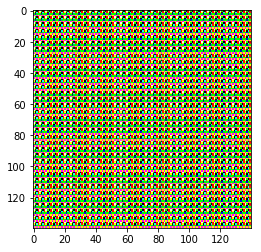

Epoch 1/2... Discriminator Loss: 0.0108... Generator Loss: 4.5399
Epoch 1/2... Discriminator Loss: 0.0094... Generator Loss: 4.7018
Epoch 1/2... Discriminator Loss: 0.0092... Generator Loss: 4.7204
Epoch 1/2... Discriminator Loss: 0.0067... Generator Loss: 5.0109
Epoch 1/2... Discriminator Loss: 0.0060... Generator Loss: 5.1230


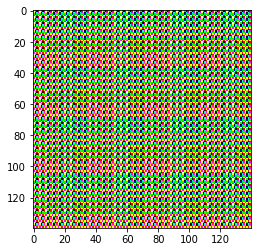

Epoch 1/2... Discriminator Loss: 0.0053... Generator Loss: 5.2630
Epoch 1/2... Discriminator Loss: 0.0059... Generator Loss: 5.2933
Epoch 1/2... Discriminator Loss: 0.0035... Generator Loss: 5.7851
Epoch 1/2... Discriminator Loss: 0.0049... Generator Loss: 5.4536
Epoch 1/2... Discriminator Loss: 0.0040... Generator Loss: 5.5179


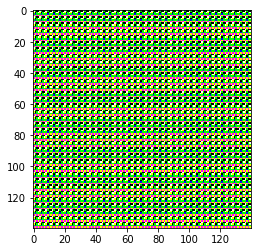

Epoch 1/2... Discriminator Loss: 0.0029... Generator Loss: 5.8559
Epoch 1/2... Discriminator Loss: 0.0046... Generator Loss: 5.4179
Epoch 1/2... Discriminator Loss: 0.0030... Generator Loss: 5.8201
Epoch 1/2... Discriminator Loss: 0.0033... Generator Loss: 5.7763
Epoch 1/2... Discriminator Loss: 0.0031... Generator Loss: 5.8468


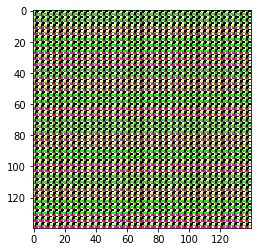

Epoch 1/2... Discriminator Loss: 0.0033... Generator Loss: 5.7317
Epoch 1/2... Discriminator Loss: 0.0026... Generator Loss: 6.0389
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 6.0545
Epoch 1/2... Discriminator Loss: 0.0029... Generator Loss: 6.1237
Epoch 1/2... Discriminator Loss: 0.0017... Generator Loss: 6.4203


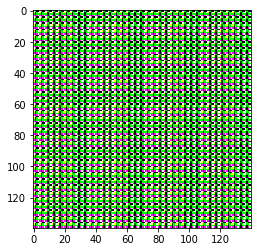

Epoch 1/2... Discriminator Loss: 0.0019... Generator Loss: 6.2820
Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 6.2212
Epoch 1/2... Discriminator Loss: 0.0019... Generator Loss: 6.3276
Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 6.0275
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 6.3102


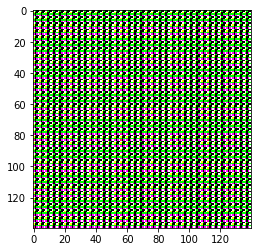

Epoch 1/2... Discriminator Loss: 0.0038... Generator Loss: 5.7008
Epoch 1/2... Discriminator Loss: 0.0022... Generator Loss: 6.1635
Epoch 1/2... Discriminator Loss: 0.0019... Generator Loss: 6.2945
Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 6.4639
Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 6.6365


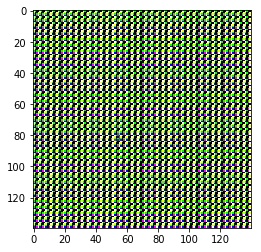

Epoch 1/2... Discriminator Loss: 0.0021... Generator Loss: 6.4148
Epoch 1/2... Discriminator Loss: 0.0028... Generator Loss: 5.8838
Epoch 1/2... Discriminator Loss: 0.0047... Generator Loss: 5.4029
Epoch 1/2... Discriminator Loss: 0.0069... Generator Loss: 5.0202
Epoch 1/2... Discriminator Loss: 0.0038... Generator Loss: 5.6376


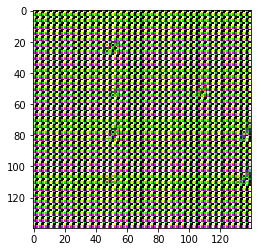

Epoch 1/2... Discriminator Loss: 0.0037... Generator Loss: 5.7222
Epoch 1/2... Discriminator Loss: 0.0029... Generator Loss: 5.9503
Epoch 1/2... Discriminator Loss: 0.0045... Generator Loss: 5.5488
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 6.8992
Epoch 1/2... Discriminator Loss: 0.0024... Generator Loss: 6.1724


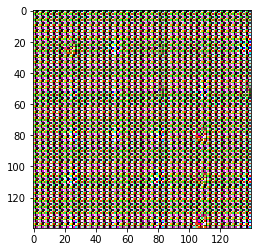

Epoch 1/2... Discriminator Loss: 0.0087... Generator Loss: 4.8109
Epoch 1/2... Discriminator Loss: 0.0078... Generator Loss: 4.9551
Epoch 1/2... Discriminator Loss: 0.0057... Generator Loss: 5.1966
Epoch 1/2... Discriminator Loss: 0.0051... Generator Loss: 5.3296
Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 5.9794


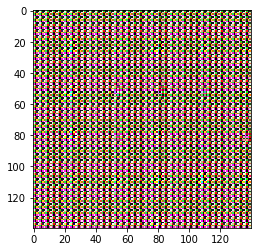

Epoch 1/2... Discriminator Loss: 0.0071... Generator Loss: 4.9922
Epoch 1/2... Discriminator Loss: 0.0059... Generator Loss: 5.1668
Epoch 1/2... Discriminator Loss: 0.0079... Generator Loss: 4.8990
Epoch 1/2... Discriminator Loss: 0.0116... Generator Loss: 4.5031
Epoch 1/2... Discriminator Loss: 0.0054... Generator Loss: 5.2788


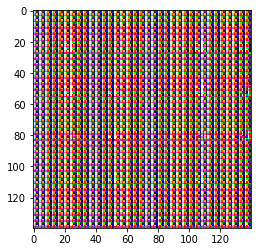

Epoch 1/2... Discriminator Loss: 0.0047... Generator Loss: 5.4128
Epoch 1/2... Discriminator Loss: 0.0155... Generator Loss: 4.2570
Epoch 1/2... Discriminator Loss: 0.0147... Generator Loss: 4.3115
Epoch 1/2... Discriminator Loss: 0.0286... Generator Loss: 3.8601
Epoch 1/2... Discriminator Loss: 0.0011... Generator Loss: 10.2611


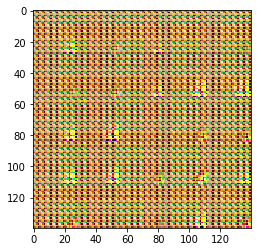

Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.8111
Epoch 1/2... Discriminator Loss: 0.0141... Generator Loss: 4.9437
Epoch 1/2... Discriminator Loss: 0.0242... Generator Loss: 3.8900
Epoch 1/2... Discriminator Loss: 0.0245... Generator Loss: 3.9749
Epoch 1/2... Discriminator Loss: 0.4011... Generator Loss: 28.7148


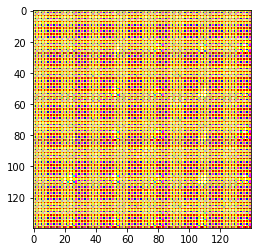

Epoch 1/2... Discriminator Loss: 0.0010... Generator Loss: 8.4337
Epoch 1/2... Discriminator Loss: 0.0079... Generator Loss: 18.8243
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 19.4659
Epoch 1/2... Discriminator Loss: 3.4880... Generator Loss: 31.6826
Epoch 1/2... Discriminator Loss: 7.2997... Generator Loss: 20.4588


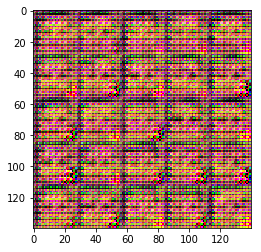

Epoch 1/2... Discriminator Loss: 12.5027... Generator Loss: 14.8239
Epoch 1/2... Discriminator Loss: 2.3583... Generator Loss: 3.9011
Epoch 1/2... Discriminator Loss: 3.0000... Generator Loss: 4.5010
Epoch 1/2... Discriminator Loss: 1.7994... Generator Loss: 2.4060
Epoch 1/2... Discriminator Loss: 3.4747... Generator Loss: 4.3654


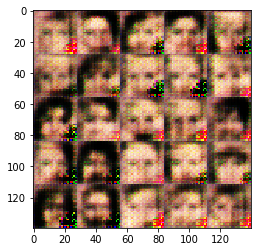

Epoch 1/2... Discriminator Loss: 2.7088... Generator Loss: 2.6809
Epoch 1/2... Discriminator Loss: 2.2015... Generator Loss: 2.9281
Epoch 1/2... Discriminator Loss: 1.9964... Generator Loss: 2.6301
Epoch 1/2... Discriminator Loss: 1.7121... Generator Loss: 2.5811
Epoch 1/2... Discriminator Loss: 2.2939... Generator Loss: 0.1838


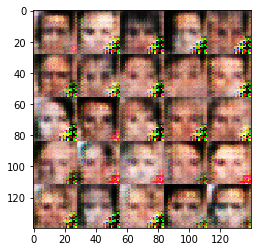

Epoch 1/2... Discriminator Loss: 2.2192... Generator Loss: 0.1734
Epoch 1/2... Discriminator Loss: 2.2008... Generator Loss: 0.2209
Epoch 1/2... Discriminator Loss: 2.0666... Generator Loss: 0.1925
Epoch 1/2... Discriminator Loss: 2.1511... Generator Loss: 2.3073
Epoch 1/2... Discriminator Loss: 1.6381... Generator Loss: 1.0000


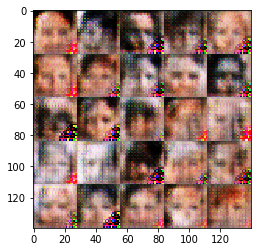

Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 1.8237... Generator Loss: 2.0722
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 1.0974
Epoch 1/2... Discriminator Loss: 1.9751... Generator Loss: 1.7165
Epoch 1/2... Discriminator Loss: 1.5913... Generator Loss: 1.2301


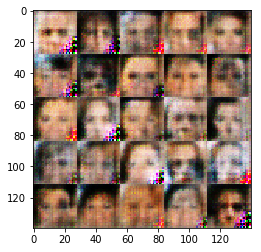

Epoch 1/2... Discriminator Loss: 1.5906... Generator Loss: 1.7593
Epoch 1/2... Discriminator Loss: 1.8245... Generator Loss: 1.4792
Epoch 1/2... Discriminator Loss: 2.0168... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.7613... Generator Loss: 1.5396
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 1.0930


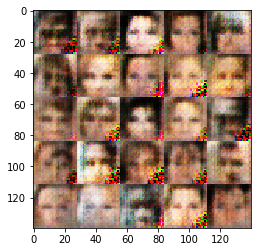

Epoch 1/2... Discriminator Loss: 1.5957... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 1.8044... Generator Loss: 0.3905
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.3362
Epoch 1/2... Discriminator Loss: 1.5402... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 1.6733... Generator Loss: 0.7077


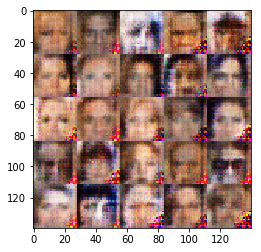

Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 1.3159
Epoch 1/2... Discriminator Loss: 1.6304... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 1.0161
Epoch 1/2... Discriminator Loss: 2.0050... Generator Loss: 0.2296
Epoch 1/2... Discriminator Loss: 1.6694... Generator Loss: 0.3213


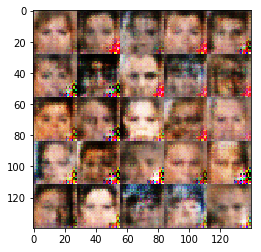

Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 1.0892
Epoch 1/2... Discriminator Loss: 1.5757... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.5968... Generator Loss: 0.3497
Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.6375... Generator Loss: 0.7302


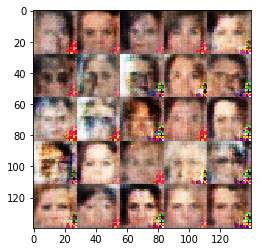

Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 1.5529... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.6804... Generator Loss: 0.3361
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 1.6313... Generator Loss: 1.1106


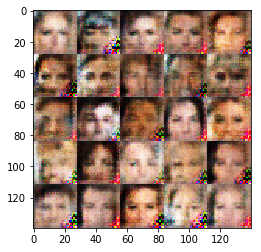

Epoch 1/2... Discriminator Loss: 1.6311... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 1.6080... Generator Loss: 0.9999
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 1.5104... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.6620... Generator Loss: 1.0701


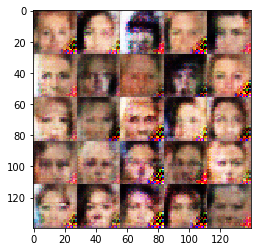

Epoch 1/2... Discriminator Loss: 1.5190... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.6494
Epoch 1/2... Discriminator Loss: 1.5336... Generator Loss: 0.8030
Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 0.9896
Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.6459


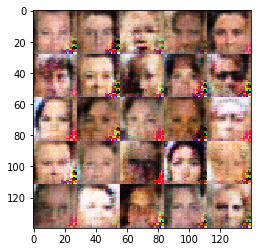

Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.3793
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.3426
Epoch 1/2... Discriminator Loss: 1.6493... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 0.5851


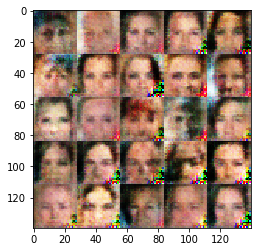

Epoch 1/2... Discriminator Loss: 1.5441... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 0.4344
Epoch 1/2... Discriminator Loss: 1.7354... Generator Loss: 0.3036
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.9391
Epoch 1/2... Discriminator Loss: 1.5679... Generator Loss: 0.7423


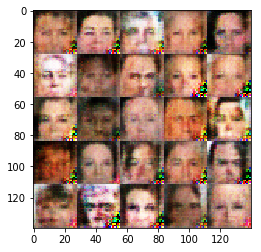

Epoch 1/2... Discriminator Loss: 1.5965... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 1.5735... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.5509


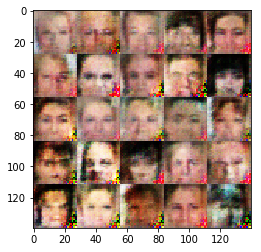

Epoch 1/2... Discriminator Loss: 1.6123... Generator Loss: 0.3577
Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.7417
Epoch 1/2... Discriminator Loss: 1.7059... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.7288... Generator Loss: 0.2845
Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 0.4407


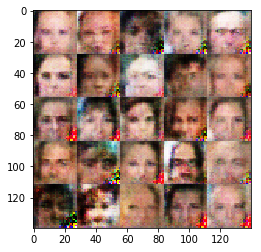

Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 1.5484... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 1.8233... Generator Loss: 0.2874
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.7229... Generator Loss: 0.3455


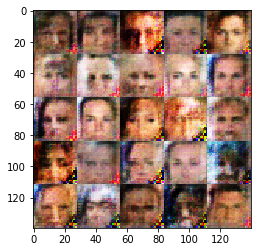

Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 0.2870
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.7275... Generator Loss: 0.2871
Epoch 2/2... Discriminator Loss: 1.4982... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.4966... Generator Loss: 0.7791


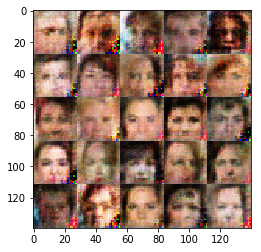

Epoch 2/2... Discriminator Loss: 1.5262... Generator Loss: 0.6656
Epoch 2/2... Discriminator Loss: 1.6695... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 1.6505... Generator Loss: 0.3240
Epoch 2/2... Discriminator Loss: 1.8278... Generator Loss: 0.2592
Epoch 2/2... Discriminator Loss: 1.7007... Generator Loss: 0.3244


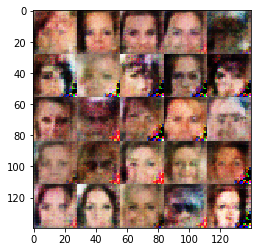

Epoch 2/2... Discriminator Loss: 1.7138... Generator Loss: 0.5800
Epoch 2/2... Discriminator Loss: 1.6233... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 1.7883... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 1.5983... Generator Loss: 0.3529
Epoch 2/2... Discriminator Loss: 1.5334... Generator Loss: 0.5072


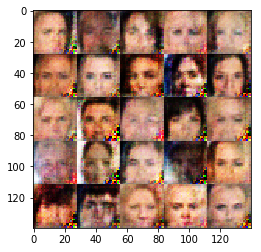

Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.6643
Epoch 2/2... Discriminator Loss: 1.6460... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 1.6239... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 1.6243... Generator Loss: 0.3789


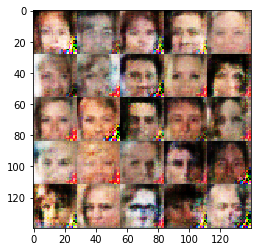

Epoch 2/2... Discriminator Loss: 1.5374... Generator Loss: 0.5434
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 1.4758... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 1.7389... Generator Loss: 0.2722
Epoch 2/2... Discriminator Loss: 1.7865... Generator Loss: 0.3078


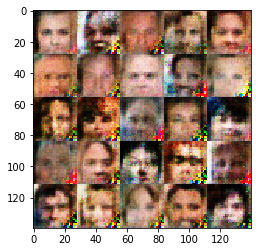

Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.4905
Epoch 2/2... Discriminator Loss: 1.8529... Generator Loss: 0.2452
Epoch 2/2... Discriminator Loss: 1.7323... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 1.6468... Generator Loss: 0.4445
Epoch 2/2... Discriminator Loss: 1.7265... Generator Loss: 0.6165


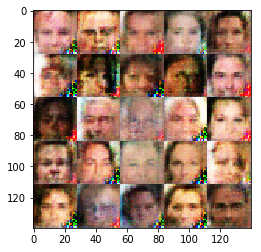

Epoch 2/2... Discriminator Loss: 1.6919... Generator Loss: 0.2885
Epoch 2/2... Discriminator Loss: 1.5598... Generator Loss: 0.3635
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.4882... Generator Loss: 0.4634
Epoch 2/2... Discriminator Loss: 1.6161... Generator Loss: 0.4373


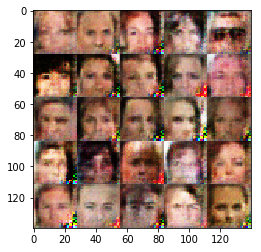

Epoch 2/2... Discriminator Loss: 1.7086... Generator Loss: 0.3138
Epoch 2/2... Discriminator Loss: 1.5932... Generator Loss: 0.3545
Epoch 2/2... Discriminator Loss: 1.6855... Generator Loss: 0.3210
Epoch 2/2... Discriminator Loss: 1.5121... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.6177... Generator Loss: 0.3328


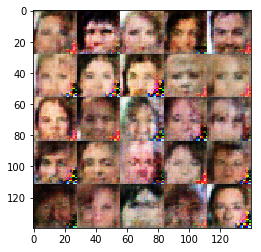

Epoch 2/2... Discriminator Loss: 1.7208... Generator Loss: 0.8446
Epoch 2/2... Discriminator Loss: 1.7336... Generator Loss: 1.1228
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 1.7375... Generator Loss: 0.2935


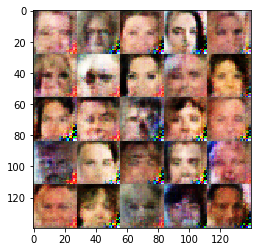

Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.5749
Epoch 2/2... Discriminator Loss: 1.6650... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 1.5785... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 1.6076... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.6508... Generator Loss: 0.3384


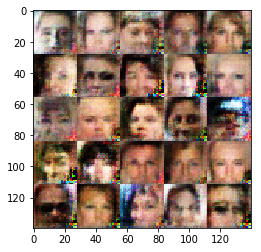

Epoch 2/2... Discriminator Loss: 1.5096... Generator Loss: 0.4628
Epoch 2/2... Discriminator Loss: 1.5573... Generator Loss: 0.3624
Epoch 2/2... Discriminator Loss: 1.5163... Generator Loss: 0.4134
Epoch 2/2... Discriminator Loss: 1.6116... Generator Loss: 0.3781
Epoch 2/2... Discriminator Loss: 1.5487... Generator Loss: 0.3890


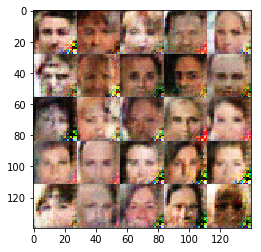

Epoch 2/2... Discriminator Loss: 1.5695... Generator Loss: 0.3970
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.4986
Epoch 2/2... Discriminator Loss: 1.6912... Generator Loss: 0.3817
Epoch 2/2... Discriminator Loss: 1.6606... Generator Loss: 0.3961
Epoch 2/2... Discriminator Loss: 1.5046... Generator Loss: 0.7821


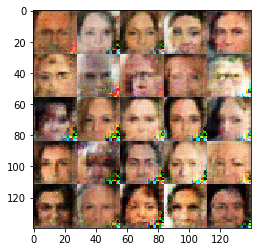

Epoch 2/2... Discriminator Loss: 1.7756... Generator Loss: 1.0630
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.5335... Generator Loss: 0.3795
Epoch 2/2... Discriminator Loss: 1.4964... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.4641


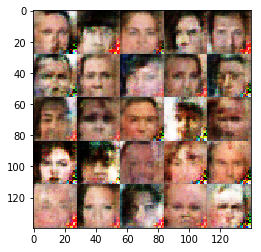

Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 1.5539... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.5258
Epoch 2/2... Discriminator Loss: 1.6315... Generator Loss: 0.8939
Epoch 2/2... Discriminator Loss: 1.5495... Generator Loss: 0.3566


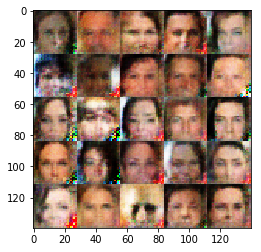

Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.4446... Generator Loss: 0.5800
Epoch 2/2... Discriminator Loss: 1.6706... Generator Loss: 0.6048
Epoch 2/2... Discriminator Loss: 1.6207... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 1.5381... Generator Loss: 0.9239


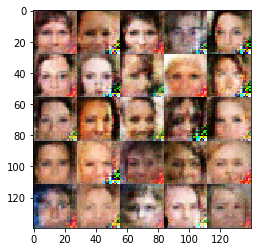

Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.5220... Generator Loss: 0.8231
Epoch 2/2... Discriminator Loss: 1.5592... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.6115... Generator Loss: 1.0971


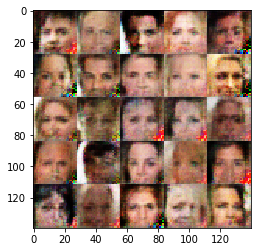

Epoch 2/2... Discriminator Loss: 1.5986... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.7165... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 1.6965... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 1.5100... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.4846


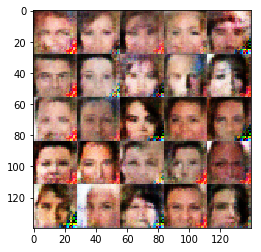

Epoch 2/2... Discriminator Loss: 1.5501... Generator Loss: 0.4024
Epoch 2/2... Discriminator Loss: 1.5978... Generator Loss: 0.4690
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.7033... Generator Loss: 0.3797
Epoch 2/2... Discriminator Loss: 1.5732... Generator Loss: 0.5348


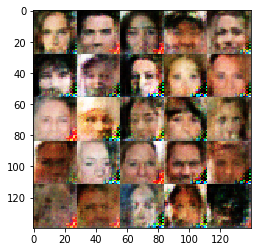

Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.5342... Generator Loss: 0.3981
Epoch 2/2... Discriminator Loss: 1.6011... Generator Loss: 0.3516
Epoch 2/2... Discriminator Loss: 1.6372... Generator Loss: 0.4462


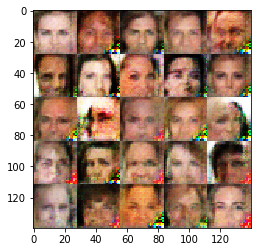

Epoch 2/2... Discriminator Loss: 1.5175... Generator Loss: 0.5481
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.4981
Epoch 2/2... Discriminator Loss: 1.6079... Generator Loss: 0.3795
Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.5053... Generator Loss: 0.3514


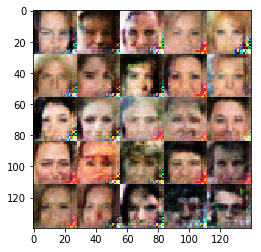

Epoch 2/2... Discriminator Loss: 1.8954... Generator Loss: 0.2371
Epoch 2/2... Discriminator Loss: 1.6293... Generator Loss: 0.3686
Epoch 2/2... Discriminator Loss: 1.5379... Generator Loss: 0.3667
Epoch 2/2... Discriminator Loss: 1.5396... Generator Loss: 0.4274
Epoch 2/2... Discriminator Loss: 1.6557... Generator Loss: 0.3527


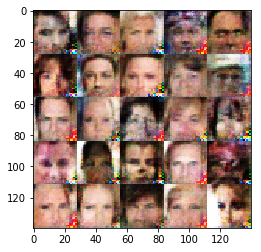

Epoch 2/2... Discriminator Loss: 1.7146... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 1.5274... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.5804... Generator Loss: 0.3629
Epoch 2/2... Discriminator Loss: 1.4421... Generator Loss: 1.1604


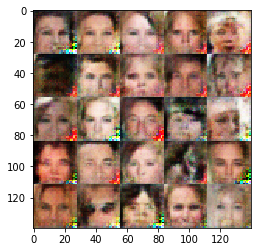

Epoch 2/2... Discriminator Loss: 1.5465... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.6564... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 1.5890... Generator Loss: 0.5867
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 1.5169... Generator Loss: 0.6378


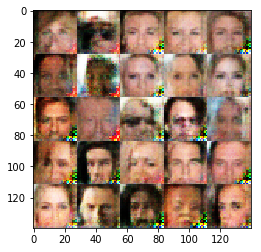

Epoch 2/2... Discriminator Loss: 1.5295... Generator Loss: 0.3749
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 1.5733... Generator Loss: 0.3527
Epoch 2/2... Discriminator Loss: 1.4852... Generator Loss: 0.5181
Epoch 2/2... Discriminator Loss: 1.5899... Generator Loss: 0.6128


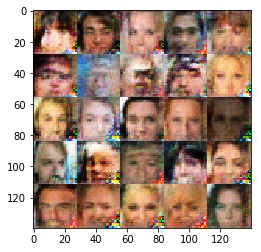

Epoch 2/2... Discriminator Loss: 1.4391... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 1.6299... Generator Loss: 0.3096
Epoch 2/2... Discriminator Loss: 1.6613... Generator Loss: 0.3600
Epoch 2/2... Discriminator Loss: 1.5405... Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 1.5546... Generator Loss: 0.6298


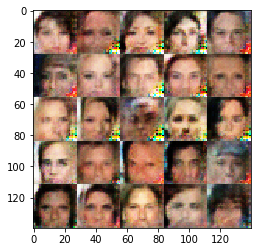

Epoch 2/2... Discriminator Loss: 1.6811... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 1.5624... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.5654... Generator Loss: 0.4589
Epoch 2/2... Discriminator Loss: 1.5065... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 0.2978


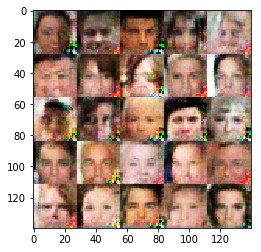

Epoch 2/2... Discriminator Loss: 1.4760... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 1.5634... Generator Loss: 0.8658
Epoch 2/2... Discriminator Loss: 1.4428... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.5029


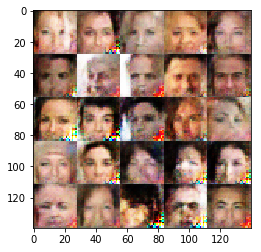

Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 1.0078
Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 1.6197... Generator Loss: 0.3480
Epoch 2/2... Discriminator Loss: 1.8067... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.6254


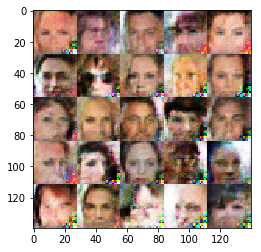

Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 1.6526... Generator Loss: 1.1124
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.6266... Generator Loss: 0.3336
Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.6055


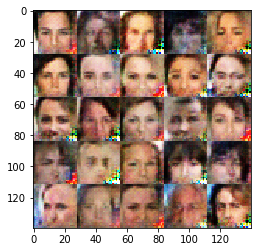

Epoch 2/2... Discriminator Loss: 1.6344... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 1.6692... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 0.4546
Epoch 2/2... Discriminator Loss: 1.6961... Generator Loss: 0.3163
Epoch 2/2... Discriminator Loss: 1.4965... Generator Loss: 0.4597


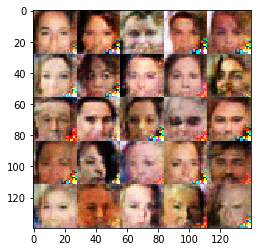

Epoch 2/2... Discriminator Loss: 1.4942... Generator Loss: 0.5678
Epoch 2/2... Discriminator Loss: 1.4432... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 1.5343... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 1.6401... Generator Loss: 0.8077


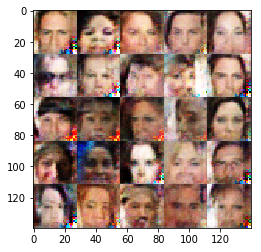

Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 0.5983


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.